<a href="https://colab.research.google.com/github/skyrag/arn_lab1/blob/main/arn_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fold  0
train: %s [[9.12315045e-06 1.36561475e-05 1.28317988e-05 ... 1.31561694e-06
  1.88253500e-06 3.55532109e-07]
 [1.08095901e-05 7.67086240e-05 3.43861975e-05 ... 3.17965402e-07
  3.83331752e-07 2.46632396e-07]
 [3.21241259e-06 3.08873277e-05 4.41908232e-05 ... 2.85465632e-07
  9.18769501e-07 5.57924125e-07]
 ...
 [1.62138767e-05 2.84640701e-05 3.14285789e-05 ... 1.22219163e-07
  1.27733472e-07 2.25666255e-07]
 [1.28606980e-05 1.36000399e-05 1.97660538e-05 ... 8.17007844e-07
  6.63020728e-07 9.61558953e-07]
 [3.54205235e-06 5.87464774e-06 1.07878577e-05 ... 3.68524252e-06
  7.30184752e-07 1.33459343e-06]]
test: %s [[9.7950606e-06 9.5739406e-06 1.1024227e-05 ... 8.9586655e-07
  2.8650393e-07 8.2809350e-07]
 [1.1652465e-05 3.1402640e-05 2.3917843e-05 ... 9.1464625e-07
  4.1769374e-07 6.3444008e-07]
 [8.1991730e-06 2.3801601e-06 2.5496408e-06 ... 2.7289238e-07
  6.2229549e-07 4.5304515e-07]
 ...
 [2.5190859e-05 7.7235709e-06 1.2473907e-05 ... 3.0806791e-07
  4.0739198e-07 4.5185126e-

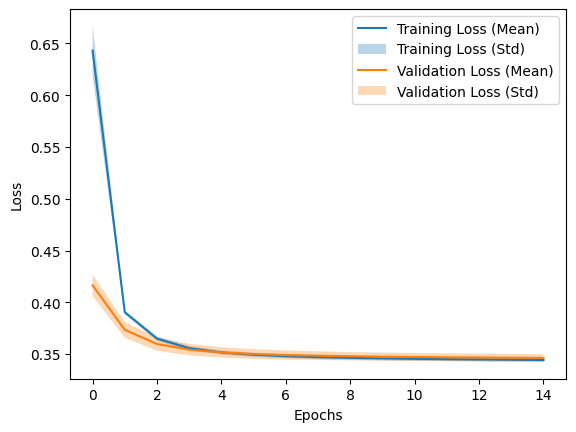

In [32]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as pl
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import layers

mice_eeg1 = pd.read_csv('EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('EEG_mouse_data_2.csv')
mice_eeg = pd.concat([mice_eeg1, mice_eeg2])
mice_eeg = np.array(mice_eeg)

scaler = StandardScaler()

mice_eeg_input = mice_eeg[:, 1:26:]
mice_eeg_input = mice_eeg_input.astype('float32')
mice_eeg_output = mice_eeg[:, 0:1:]

# At first, we only want an awake state and an asleep state
mice_eeg_output[mice_eeg_output == 'w'] = 1
mice_eeg_output[mice_eeg_output == 'n'] = -1
mice_eeg_output[mice_eeg_output == 'r'] = -1
mice_eeg_output = mice_eeg_output.astype('float32')

#mice_eeg = (mice_eeg - mice_eeg.mean()) / mice_eeg.std()
# mice_eeg
#mice_eeg_normalize = sk.preprocessing.normalize(mice_eeg)



#3-Fold
pl.clf()
keras.utils.set_random_seed(123)
kfold = KFold(n_splits=3, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold.split(mice_eeg)):
    print(f"Fold ", i)
    print('train: %s', (mice_eeg_input[train_index]))
    print('test: %s', (mice_eeg_input[test_index]))


#Création du modèle
def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(shape=(25,)),
      layers.Dense(128, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(32, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.99),
      loss="mse",
  )

  return mlp

mlp = create_model()
mlp.summary()

history_list = []
trained_mlp = []

for i, (train_index, test_index) in enumerate(kfold.split(mice_eeg_input)):
  # We need to create a new model everytime otherwise fit will continue previous training
  scaler = StandardScaler()
  mlp = create_model()

  history = mlp.fit(
      #x=mice_eeg_input[train_index], y=mice_eeg_output[train_index],
      x=scaler.fit_transform(mice_eeg_input[train_index]), y=mice_eeg_output[train_index],
      validation_data=(scaler.transform(mice_eeg_input[test_index]), mice_eeg_output[test_index]),
      epochs=15
  )

  history_list.append(history)
  trained_mlp.append(mlp)


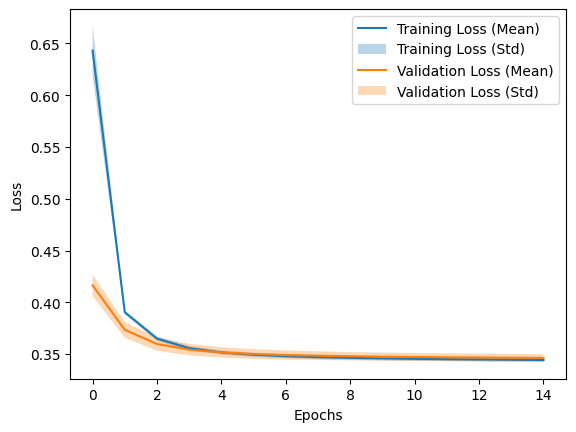

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


ValueError: Found input variables with inconsistent numbers of samples: [13621, 435872]

In [38]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

#Plot

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

#Confusion Matrix

def plot_confusion_matrix(confusion_matrix, title, class_labels):
    # Plot confusion matrix
    fig, ax = pl.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=False, fmt='', cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)

    # Add numerical values to the heatmap
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            x = j + 0.5  # Shift x-coordinate to center the text
            y = i + 0.5  # Shift y-coordinate to center the text
            ax.text(x, y, str(confusion_matrix[i, j]), ha="center", va="center", color="black")

    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    pl.show()

class_labels = ['Awake', 'Asleep']

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

for i, (train_index, test_index) in enumerate(kfold.split(mice_eeg_input)):
    # Evaluate the trained model on the test fold
    predictions = (trained_mlp[i].predict(scaler.transform(mice_eeg_input[test_index])) > 0).astype(int)
    true_labels = (mice_eeg_output[test_index] > 0).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}',class_labels)

    # Compute F1 score
    f1 = f1_score(true_labels, predictions)
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix.astype(int), 'Global confusion matrix', class_labels)

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")